In [1]:
import sys
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
# import sklearn as sk
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.model_selection import cross_val_score
# from sklearn.tree import DecisionTreeClassifier

In [2]:
KB=1024
MB=KB*1024
GB=MB*1024
TB=GB*1024

In [3]:
dss=['data/xcache_2022-06-01.parquet','data/xcache_2022-07-01.parquet','data/xcache_2022-08-01.parquet',
'data/xcache_2022-09-01.parquet','data/xcache_2022-10-01.parquet','data/xcache_2022-11-01.parquet','data/xcache_2022-12-01.parquet']
dss=['data/xcache_2023-01-01.parquet']
df=pd.DataFrame()
for i in dss:
    print(i)
    df = pd.concat([df,pd.read_parquet(i)])  
df.drop(columns=['host'],inplace=True)
(df[df['scope']=='panda']).head()

data/xcache_2023-01-01.parquet


,access,site,lfn,scope,fn,b_hit,b_miss,b_bypass,fsize,fill
27,5,BNL,atlas/rucio/panda/f9/1a/panda.0123033047.63560...,panda,panda.0123033047.635605.lib._32030111.31332326...,407263448,0,0,182660204,1.0
162,1,BNL,atlas/rucio/panda/e4/c4/panda.um.user.kenelson...,panda,panda.um.user.kenelson.signals_mc16a.601119.e8...,70919,65536,0,136455,1.0
164,1,BNL,atlas/rucio/panda/fa/fe/panda.um.user.kenelson...,panda,panda.um.user.kenelson.32026894._000001.hist-o...,0,10224,0,10224,1.0
169,1,BNL,atlas/rucio/panda/9e/64/panda.um.user.kenelson...,panda,panda.um.user.kenelson.32026894._000001.skim.root,0,407,0,407,1.0
170,1,BNL,atlas/rucio/panda/8a/c7/panda.um.user.kenelson...,panda,panda.um.user.kenelson.32026894._000001.tree.root,27836644,9306112,0,37142756,1.0


In [4]:
def Acc(r):
    cols = ['Accesses','tot files','avg acc per file', 'fill']
    return pd.Series( (
            r.access.sum(), r.shape[0], r.access.sum()/r.shape[0], 
            r.fill.mean())
            , index=cols)

def perc_read(r):
    cols = ['accesses', 'read perc', 'tot hit [TB]', 'tot miss[TB]', 'tot bypass [TB]']
    return pd.Series( 
        ( r.shape[0],  
         ( r.b_hit.sum() + r.b_miss.sum() + r.b_bypass.sum() ) / r.fsize.sum(),
         r.b_hit.sum()/TB, 
         r.b_miss.sum()/TB, 
         r.b_bypass.sum()/TB 
        ) ,
        index=cols
    )


In [5]:
df['ext']=df.fn.str.split('.').str[-2]+'.'+df.fn.str.split('.').str[-1]

df['ext1'] = np.where(df['ext'].str.find('root')>-1, 'root', df['ext'] )
df['ext1'] = np.where(df['ext1'].str.endswith('.1'), 'root', df['ext1'] )

df.groupby('ext1').apply(perc_read).sort_values('accesses',ascending=False).head()

,accesses,read perc,tot hit [TB],tot miss[TB],tot bypass [TB]
ext1,,,,,
root,2062834.0,0.196561,617.667781,184.158941,2.037490e+01
log.tgz,70754.0,1.005344,0.006686,0.005384,4.603880e-07
lib.tgz,20805.0,2.235586,4.649653,0.115485,0.000000e+00
_0001.data,367.0,1.000000,0.783023,0.008771,0.000000e+00
_0003.data,358.0,1.000000,0.615938,0.009261,0.000000e+00


In [6]:
perc_read(df)

accesses           2.155932e+06
read perc          1.981216e-01
tot hit [TB]       6.249628e+02
tot miss[TB]       1.843533e+02
tot bypass [TB]    2.037490e+01
dtype: float64

prints percentage of file read in an average access.
Total data delivered on hit (in TB), on miss, and bypassed.

the same but grouped per scope

In [7]:
print(df.groupby('scope').apply(perc_read).sort_values('accesses',ascending=False).to_string())

                accesses  read perc  tot hit [TB]  tot miss[TB]  tot bypass [TB]
scope                                                                           
mc16_13TeV      796644.0   0.243614  4.353537e+02  1.104490e+02     2.012730e+01
data18_13TeV    383774.0   0.100753  3.146988e+01  1.176117e+01     4.417165e-06
panda           203142.0   1.240920  1.062855e+01  2.054751e+00     6.385680e-04
data17_13TeV    141565.0   0.150625  1.831726e+01  7.197257e+00     2.852433e-06
data16_13TeV    133326.0   0.310604  4.280091e+01  8.651023e+00     1.847837e-01
mc20_13TeV       80481.0   0.080584  1.828258e+01  1.232825e+01     5.616331e-02
data22_13p6TeV   68613.0   0.050070  4.811232e+00  2.154159e+00     2.148718e-03
mc21_13p6TeV     61174.0   0.610997  3.745232e+01  1.049960e+01     3.627132e-03
user.abagdato    60969.0   0.198591  2.546331e-01  3.220623e-01     0.000000e+00
data15_13TeV     39306.0   0.490905  1.746927e+01  2.842586e+00     1.836946e-06
mc15_13TeV       31781.0   0

and grouped by site

In [8]:
print(df.groupby('site').apply(perc_read).sort_values('accesses',ascending=False).to_string())

                      accesses  read perc  tot hit [TB]  tot miss[TB]  tot bypass [TB]
site                                                                                  
AGLT2                 694726.0   0.024201     26.962641      8.182537         0.015772
MWT2                  447184.0   0.077532     29.936388     31.536402         0.018122
BNL                   356447.0   0.096048     26.394666     41.501566         0.000000
Birmingham            288050.0   0.462417    107.388702     36.141123         0.000000
UKI-SOUTHGRID-OX-HEP  155713.0   0.999236    411.436493     48.231422        20.341006
LRZ-LMU               147314.0   0.082374     12.313927     12.541529         0.000000
SWT2                   66498.0   0.117590     10.530017      6.218711         0.000000


total number of accesses. number of unique files. average number of times files were accessed, and current file fill factor.

In [9]:
idx = df.groupby(['lfn'])['access'].transform(max) == df['access']
mdf = df[idx]
print(Acc(mdf))

Accesses            3.084898e+06
tot files           6.824900e+05
avg acc per file    4.520063e+00
fill                7.757623e-01
dtype: float64


                Accesses  tot files  avg acc per file      fill
scope                                                          
mc16_13TeV      977482.0   211108.0          4.630246  0.734366
data18_13TeV    867508.0    48621.0         17.842249  0.655332
data16_13TeV    261638.0    38469.0          6.801269  0.729319
data17_13TeV    221962.0    32669.0          6.794270  0.630707
panda           202917.0   181742.0          1.116511  0.999695
mc20_13TeV       90831.0    26980.0          3.366605  0.350212
data15_13TeV     77329.0    15946.0          4.849429  0.890065
mc21_13p6TeV     73895.0    50082.0          1.475480  0.976105
data22_13p6TeV   67411.0    18966.0          3.554308  0.292397
user.abagdato    56514.0    18863.0          2.996024  0.667574
mc15_13TeV       35088.0     8717.0          4.025238  0.719002
user.maly        27802.0     1547.0         17.971558  0.761554
mc15_valid       26487.0     5545.0          4.776736  0.818864
mc16_5TeV        23061.0    11126.0     

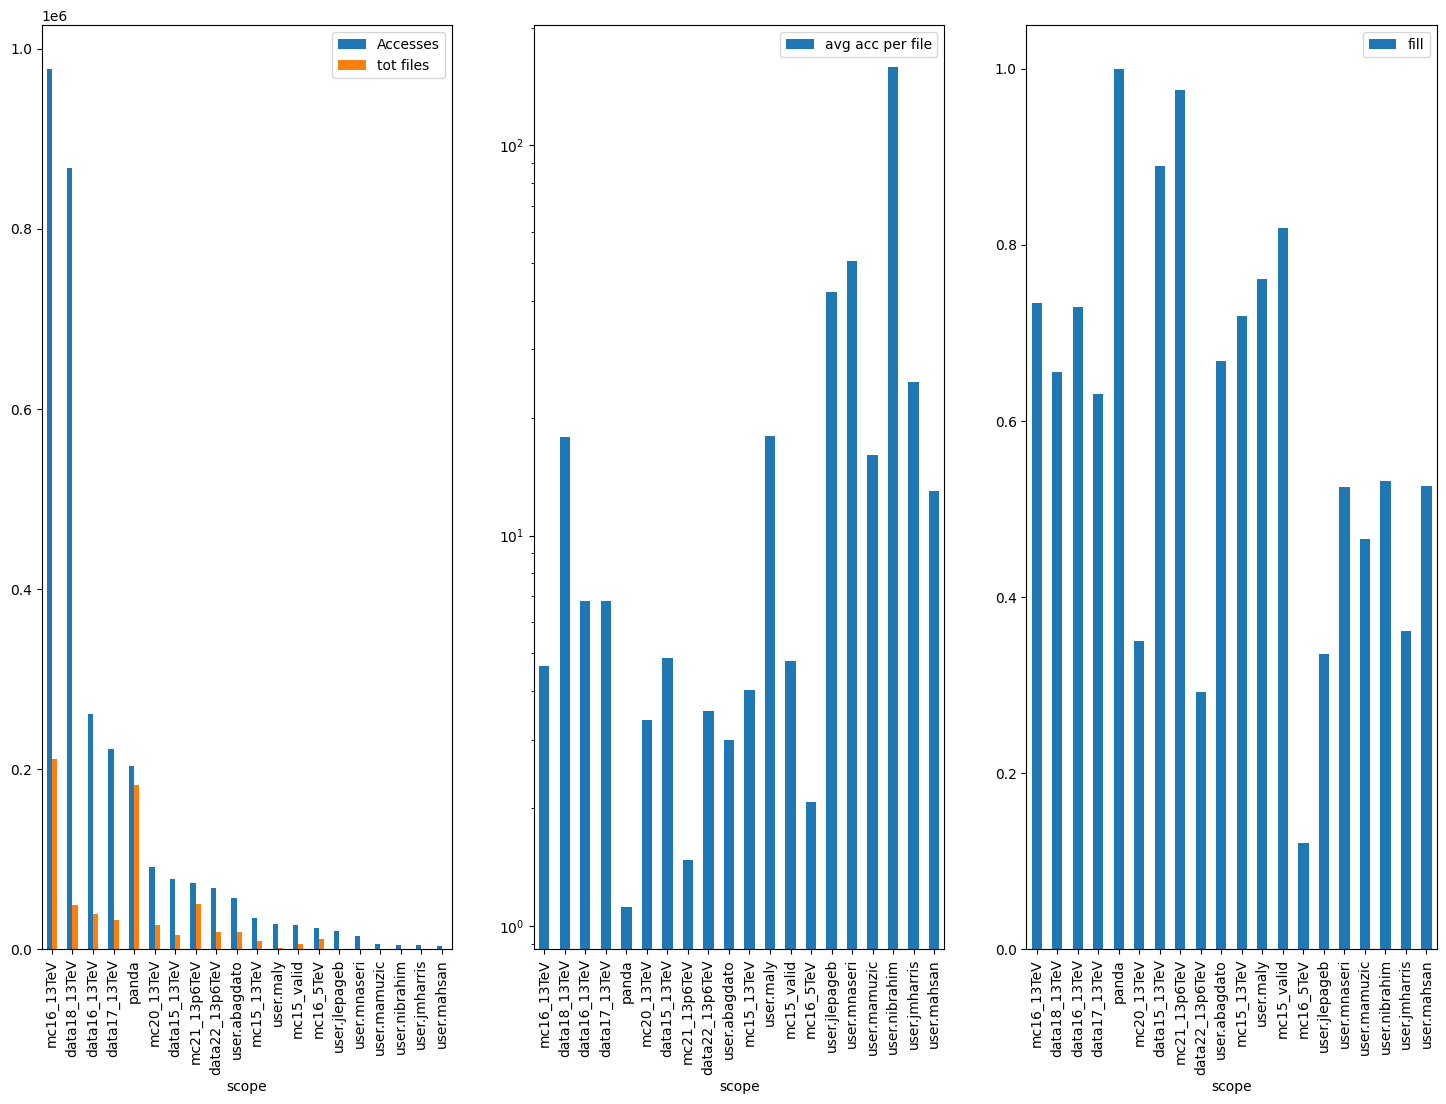

In [18]:
groups=mdf.groupby('scope').apply(Acc).sort_values('Accesses',ascending=False)
print(groups.to_string())

with plt.style.context('default'):
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
    groups[:20].plot.bar( y=['Accesses','tot files'], ax=ax1)
    groups[:20].plot.bar( y=['avg acc per file'], ax=ax2, logy=True)
    groups[:20].plot.bar( y=['fill'], ax=ax3)
    fig.set_size_inches(18, 12)
    plt.show()
    fig.savefig('accesses and files per scope.png', dpi=100)

                       Accesses  tot files  avg acc per file      fill
site                                                                  
AGLT2                 1701430.0    94248.0         18.052691  0.336214
MWT2                   403103.0   119277.0          3.379553  0.672862
Birmingham             271462.0   192658.0          1.409036  0.949324
BNL                    235180.0    98916.0          2.377573  0.861469
LRZ-LMU                202222.0    43164.0          4.684969  0.479775
UKI-SOUTHGRID-OX-HEP   175356.0   121202.0          1.446808  0.977160
SWT2                    96145.0    13025.0          7.381574  0.787319


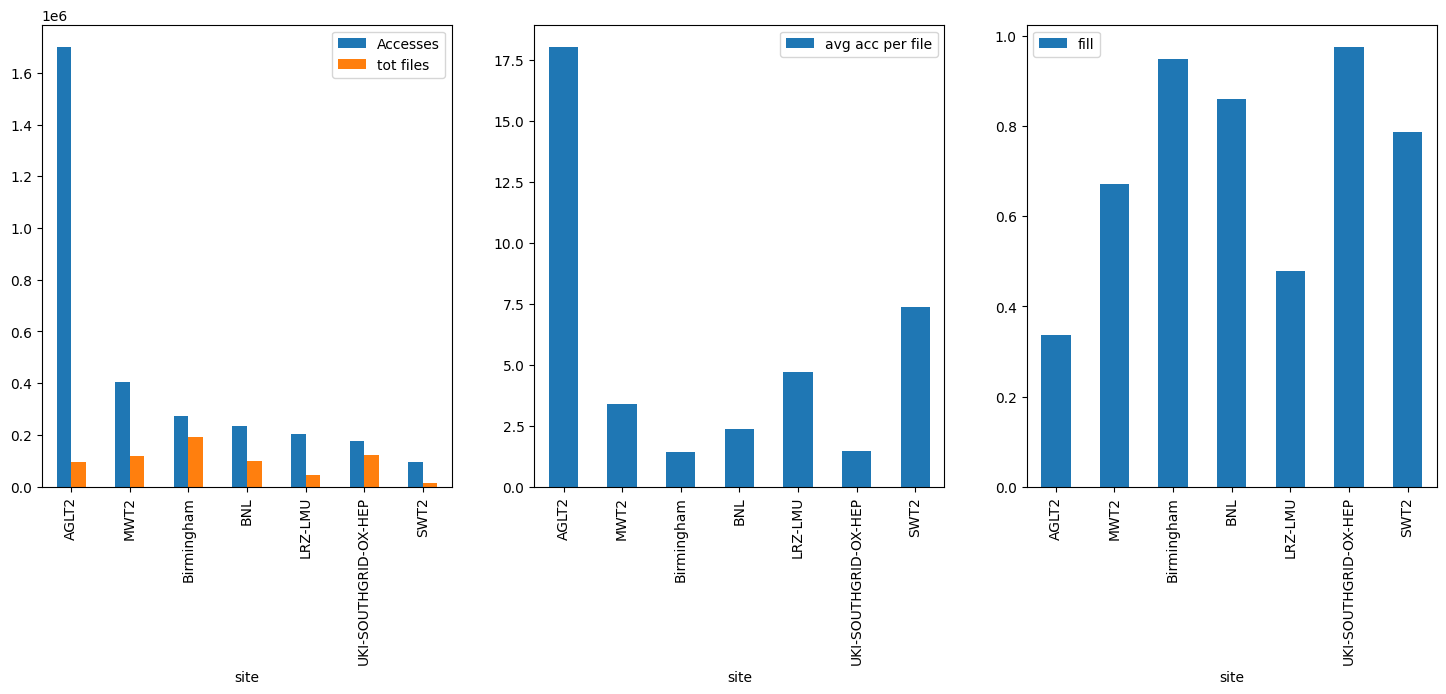

In [19]:
groups=mdf.groupby('site').apply(Acc).sort_values('Accesses',ascending=False)
print(groups.to_string())

with plt.style.context('default'):
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
    groups.plot.bar( y=['Accesses','tot files'], ax=ax1)
    groups.plot.bar( y=['avg acc per file'], ax=ax2, logy=False)
    groups.plot.bar( y=['fill'], ax=ax3)
    fig.set_size_inches(18, 6)
    plt.show()
    fig.savefig('accesses and files per site.png', dpi=100)

Frequently accessed files

In [12]:
print(mdf.groupby('ext1').apply(Acc).sort_values('Accesses',ascending=False).to_string())

             Accesses  tot files  avg acc per file      fill
ext1                                                        
root        2992025.0   607585.0          4.924455  0.748135
log.tgz       70755.0    68503.0          1.032874  0.999869
lib.tgz       20579.0     4877.0          4.219602  0.999663
_0001.data      367.0      367.0          1.000000  1.000000
_0003.data      358.0      358.0          1.000000  1.000000
_0002.data      357.0      357.0          1.000000  1.000000
_0004.data      163.0      163.0          1.000000  1.000000
output.h5       129.0      118.0          1.093220  1.000000
_0005.data       69.0       69.0          1.000000  1.000000
meta.json        61.0       60.0          1.016667  1.000000
_0001.2          20.0       20.0          1.000000  1.000000
tar.gz            8.0        6.0          1.333333  1.000000
meta.txt          6.0        6.0          1.000000  1.000000
_0004.2           1.0        1.0          1.000000  1.000000


In [13]:

# ldf.index = pd.to_datetime(ldf["time"])
# # ldf.plot(y=["loss"],figsize=(15,4), style='.')
# groups = ldf.groupby("host")
# for name, group in groups:
#     # plt.plot()
#     plt.plot(group["loss"], marker="o", linestyle="", label=name)
# plt.legend()
# fig = matplotlib.pyplot.gcf()
# fig.set_size_inches(18.5, 10.5)
# # fig.savefig('losses.png', dpi=100)